In [1]:
# %pip install dandi
# %pip install fsspec requests aiohttp


In [2]:
from dandi.dandiapi import DandiAPIClient

dandiset_id = '000402'  # ophys dataset from the Tolias Lab
filepath = 'sub-17797/sub-17797_ses-4-scan-7_behavior+image+ophys.nwb'  # 71 GB file
with DandiAPIClient() as client:
    asset = client.get_dandiset(dandiset_id, 'draft').get_asset_by_path(filepath)
    s3_url = asset.get_content_url(follow_redirects=1, strip_query=True)

In [3]:
import fsspec
import pynwb
import h5py
from fsspec.implementations.cached import CachingFileSystem

In [5]:
# first, create a virtual filesystem based on the http protocol
fs = fsspec.filesystem('http')

In [7]:
# create a cache to save downloaded data to disk (optional)
fs = CachingFileSystem(
    fs=fs,
    cache_storage='nwb-cache',  # Local folder for the cache
)

In [11]:
# next, open the file
with fs.open(s3_url, 'rb') as f:
    with h5py.File(f) as file:
        with pynwb.NWBHDF5IO(file=file, load_namespaces=True) as io:
            nwbfile = io.read()
            temp = nwbfile.acquisition['PupilTracking'].time_series['pupil_minor_radius'].data[:]


/home/vscode/.local/lib/python3.9/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.5.1 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/home/vscode/.local/lib/python3.9/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'core' version 2.5.0 because version 2.6.0-alpha is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/home/vscode/.local/lib/python3.9/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.2.0 because version 0.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


In [12]:
temp

array([72.9792, 73.3979, 72.5299, ..., 59.0967, 51.4665, 54.9787])

In [13]:
import matplotlib.pyplot as plt

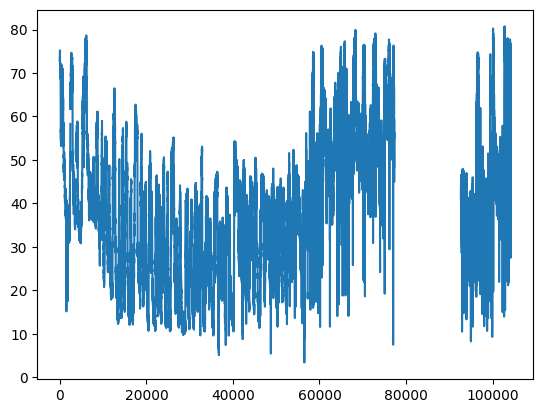

In [14]:
plt.plot(temp)